In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

rs = 42

### Cross Validation Function

In [9]:
def cross_validate(X, y, model, scale=True, rs=42, holdout=False):
    
    # If test set not already held out, create, otherwise use all the data
    if holdout:
        X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=rs)
    
    # Default is to scale
    if scale:
        sc = StandardScaler()
        X = sc.fit_transform(X)
    
    kfolds = KFold(n_splits=5, shuffle=True, random_state=rs)
    
    acc = []
    pre = []
    rec = []
    f1 = []
    roc = []
    
    for train_ind, val_ind in kfolds.split(X, y):
        X_train, y_train = X[train_ind], y[train_ind] # pull out the training folds
        X_val, y_val = X[val_ind], y[val_ind] # pull out the validation folds
        
        if scale:
            X_val = sc.transform(X_val)
        
        model.fit(X_train, y_train)
        pred_hard = model.predict(X_val)
        pred_soft = model.predict_proba(X_val)[:, 1]
        
        acc.append(accuracy_score(y_val, pred_hard))
        pre.append(precision_score(y_val, pred_hard))
        rec.append(recall_score(y_val, pred_hard))
        f1.append(f1_score(y_val, pred_hard))
        roc.append(roc_auc_score(y_val, pred_soft))
        
    print(f'Mean Accuracy: {np.mean(acc):.2f} +- {np.std(acc):.3f}')
    print(f'Mean Recall: {np.mean(rec):.2f} +- {np.std(rec):.3f}')
    print(f'Mean Precision: {np.mean(pre):.2f} +- {np.std(pre):.3f}')
    print(f'Mean F1: {np.mean(f1):.2f} +- {np.std(f1):.3f}')
    print(f'Mean ROC AUC: {np.mean(roc):.2f} +- {np.std(roc):.3f}')
    
    return pred_hard # take the last set of predictions for confusion matrix

# First Base Model - Demographic Features Only

First, try a very small set of features. Let's see how we can do just using demographic information.

In [2]:
cols2keep = ['outcome', 'subject_age', 'subject_race', 'subject_sex', 'officer_age', 'officer_race', 'officer_sex']
cols2dum = ['subject_race', 'subject_sex', 'officer_race', 'officer_sex']

df_fl_dropnas = pd.read_pickle('data/df_fl_dropnas.pkl')
df_fl_sub = df_fl_dropnas[cols2keep]
del df_fl_dropnas # for memory purposes

Dummify the categoricals

In [3]:
df_fl_sub_dums = pd.get_dummies(df_fl_sub, columns=cols2dum, prefix=cols2dum, drop_first=True)
del df_fl_sub

In [4]:
df_fl_sub_dums.head()

,outcome,subject_age,officer_age,subject_race_black,subject_race_hispanic,subject_race_other/unknown,subject_race_white,subject_sex_male,officer_race_black,officer_race_hispanic,officer_race_other/unknown,officer_race_white,officer_sex_male
1,citation,23.0,31.0,0,0,0,1,0,1,0,0,0,1
2,arrest,45.0,29.0,0,0,0,1,0,0,0,0,1,1
3,arrest,41.0,26.0,0,0,0,1,1,0,0,0,1,1
6,warning,26.0,47.0,0,0,0,1,1,0,0,0,1,1
8,warning,26.0,47.0,0,1,0,0,1,0,0,0,1,1


Binarize outcome, will start by doing binary classifier arrest vs. no arrest.

In [5]:
def binarize_outcome(df):
    df['outcome'].replace(['warning', 'citation', 'arrest'], [0, 0, 1], inplace=True)
    return df

In [6]:
df_fl_sub_dums = binarize_outcome(df_fl_sub_dums)

Set up a logistic regression on the demo df.

In [7]:
X = df_fl_sub_dums.drop('outcome', axis=1)
y = df_fl_sub_dums['outcome']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=rs)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=rs)

In [8]:
#base_logistic = LogisticRegression(class_weight={0: 1, 1: 15})
#cross_validate(X_train_val, y_train_val, base_logistic)

In [9]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)

base_logistic = LogisticRegression(class_weight={0: 1, 1: 15})
base_logistic.fit(X_train_sc, y_train)
preds = base_logistic.predict(X_val_sc)
print(f'Accuracy is {round(accuracy_score(y_val, preds), 3)}')
print(f'Precision is {round(precision_score(y_val, preds), 3)}')
print(f'Recall is {round(recall_score(y_val, preds), 3)}')
print(f'F1 is {round(f1_score(y_val, preds), 3)}')

/Users/markyramone/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy is 0.869
Precision is 0.083
Recall is 0.272
F1 is 0.128


In [10]:
list(sorted(zip(X_val.columns, base_logistic.coef_[0]), key=lambda tup: tup[1], reverse=True))

[('subject_race_black', 0.486677809861436),
 ('subject_race_hispanic', 0.45573733033291963),
 ('subject_sex_male', 0.24862282642010394),
 ('subject_race_white', 0.2266030154699556),
 ('subject_race_other/unknown', 0.043786113496502535),
 ('officer_sex_male', -0.024971973488864815),
 ('officer_race_white', -0.031676825453349544),
 ('officer_race_other/unknown', -0.06260831979031777),
 ('officer_race_hispanic', -0.08848836266362188),
 ('officer_race_black', -0.09511245036824628),
 ('officer_age', -0.1798121496958717),
 ('subject_age', -0.4026714146037133)]

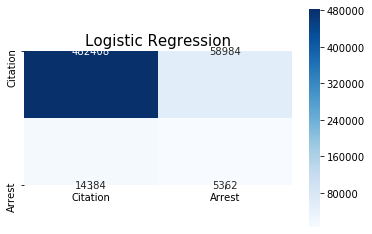

In [11]:
cm = confusion_matrix(y_val, preds)
sns.heatmap(cm,
            cmap=plt.cm.Blues,
            annot=True,
            square=True,
            xticklabels=['Citation', 'Arrest'],
            yticklabels=['Citation', 'Arrest'],
            fmt='g')
plt.title('Logistic Regression', size=15);

Generally terrible! Examine the ROC curve to see what effect the probability threshold is having. 

In [12]:
def plot_roc(y_true, pred_probs, model_type):
    # model_type: string label for the model (e.g. 'Logistic Regression')
    fpr, tpr, _ = roc_curve(y_true, pred_probs)
    auc_val = roc_auc_score(y_true, pred_probs)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr)
    plt.plot([0,1])
    plt.annotate(f'AUC = {round(auc_val, 3)}', xy=(.6, .2))
    plt.title(model_type)
    plt.xlabel('FPR')
    plt.ylabel('TPR')

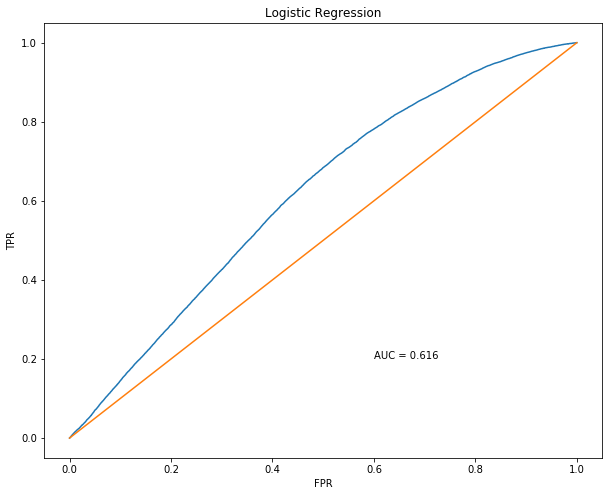

In [13]:
pred_probs = base_logistic.predict_proba(X_val)[:, 1]
plot_roc(y_val, pred_probs, 'Logistic Regression')

# Second Base Model - Add Officer Years of Service

In [14]:
cols2keep = ['outcome', 'subject_age', 'subject_race', 'subject_sex', 'officer_age', 'officer_race', 'officer_sex', 
             'officer_years_of_service']
cols2dum = ['subject_race', 'subject_sex', 'officer_race', 'officer_sex']

df_fl_dropnas = pd.read_pickle('data/df_fl_dropnas.pkl')
df_fl_sub = df_fl_dropnas[cols2keep]
del df_fl_dropnas # for memory purposes

In [15]:
# Fix negative values in officer years of service
df_fl_sub['officer_years_of_service'] = np.abs(df_fl_sub['officer_years_of_service'])

In [16]:
# Dummify
df_fl_sub_dums = pd.get_dummies(df_fl_sub, columns=cols2dum, prefix=cols2dum, drop_first=True)
del df_fl_sub

In [17]:
# Binarize outcome
df_fl_sub_dums = binarize_outcome(df_fl_sub_dums)

In [18]:
X = df_fl_sub_dums.drop('outcome', axis=1)
y = df_fl_sub_dums['outcome']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=rs)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=rs)

In [19]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)

base_logistic = LogisticRegression(class_weight={0: 1, 1: 15})
base_logistic.fit(X_train_sc, y_train)
preds = base_logistic.predict(X_val_sc)
print(f'Accuracy is {round(accuracy_score(y_val, preds), 3)}')
print(f'Precision is {round(precision_score(y_val, preds), 3)}')
print(f'Recall is {round(recall_score(y_val, preds), 3)}')
print(f'F1 is {round(f1_score(y_val, preds), 3)}')

/Users/markyramone/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy is 0.869
Precision is 0.083
Recall is 0.271
F1 is 0.128


In [20]:
list(sorted(zip(X_val.columns, base_logistic.coef_[0]), key=lambda tup: tup[1], reverse=True))

[('subject_race_black', 0.48669086211525053),
 ('subject_race_hispanic', 0.4557546113854098),
 ('subject_sex_male', 0.24862876477434712),
 ('subject_race_white', 0.22655483755549846),
 ('subject_race_other/unknown', 0.04378693806632325),
 ('officer_years_of_service', -0.002740610994218027),
 ('officer_sex_male', -0.02510557106048131),
 ('officer_race_white', -0.031463245361216585),
 ('officer_race_other/unknown', -0.06253488581586511),
 ('officer_race_hispanic', -0.08830428553928443),
 ('officer_race_black', -0.09488395726577184),
 ('officer_age', -0.17866229473806056),
 ('subject_age', -0.4026797538661274)]

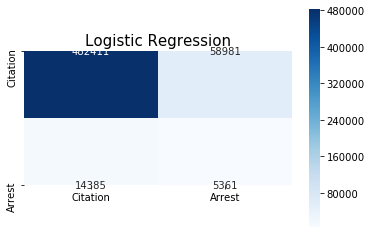

In [21]:
cm = confusion_matrix(y_val, preds)
sns.heatmap(cm,
            cmap=plt.cm.Blues,
            annot=True,
            square=True,
            xticklabels=['Citation', 'Arrest'],
            yticklabels=['Citation', 'Arrest'],
            fmt='g')
plt.title('Logistic Regression', size=15);

Adding officer years of service had minimal effect, but at least it's in the right direction.

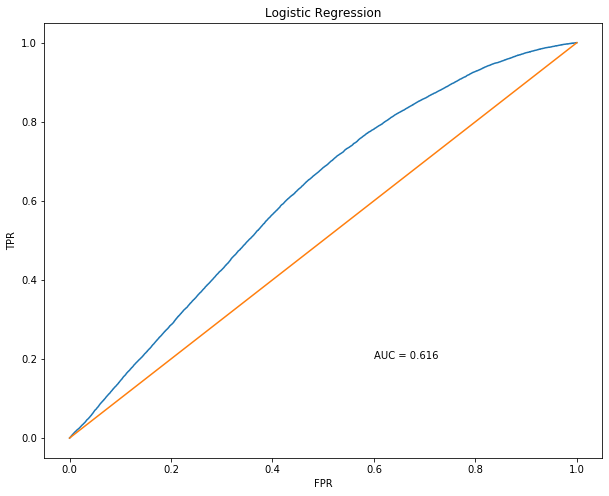

In [22]:
pred_probs = base_logistic.predict_proba(X_val)[:, 1]
plot_roc(y_val, pred_probs, 'Logistic Regression')

# Third Base Model - Add Vehicle and County Information

In [23]:
cols2keep = ['outcome', 'subject_age', 'subject_race', 'subject_sex', 'officer_age', 'officer_race', 'officer_sex', 
             'officer_years_of_service', 'county_name', 'vehicle_region']
cols2dum = ['subject_race', 'subject_sex', 'officer_race', 'officer_sex', 'county_name', 'vehicle_region']

df_fl_dropnas = pd.read_pickle('data/df_fl_dropnas.pkl')
df_fl_sub = df_fl_dropnas[cols2keep]
del df_fl_dropnas # for memory purposes

In [24]:
# Fix negative values in officer years of service
df_fl_sub['officer_years_of_service'] = np.abs(df_fl_sub['officer_years_of_service'])

In [25]:
# Dummify
df_fl_sub_dums = pd.get_dummies(df_fl_sub, columns=cols2dum, prefix=cols2dum, drop_first=True)
del df_fl_sub

In [26]:
# Binarize outcome
df_fl_sub_dums = binarize_outcome(df_fl_sub_dums)

In [27]:
X = df_fl_sub_dums.drop('outcome', axis=1)
y = df_fl_sub_dums['outcome']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=rs)

In [28]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)

base_logistic = LogisticRegression(class_weight={0: 1, 1: 15})
base_logistic.fit(X_train_sc, y_train)
preds = base_logistic.predict(X_val_sc)
print(f'Accuracy is {round(accuracy_score(y_val, preds), 3)}')
print(f'Precision is {round(precision_score(y_val, preds), 3)}')
print(f'Recall is {round(recall_score(y_val, preds), 3)}')
print(f'F1 is {round(f1_score(y_val, preds), 3)}')

/Users/markyramone/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy is 0.857
Precision is 0.087
Recall is 0.324
F1 is 0.138


In [29]:
list(sorted(zip(X_val.columns, base_logistic.coef_[0]), key=lambda tup: tup[1], reverse=True))

[('subject_race_hispanic', 0.4795455482114809),
 ('subject_race_black', 0.4706447032903552),
 ('subject_sex_male', 0.25347810875543997),
 ('subject_race_white', 0.21260028727072514),
 ('county_name_DUVAL', 0.14465920964624784),
 ('county_name_ESCAMBIA', 0.08346259577563804),
 ('county_name_NASSAU', 0.06960579359463431),
 ('subject_race_other/unknown', 0.051935230363294296),
 ('county_name_PASCO', 0.04809689130750636),
 ('county_name_PALM BEACH', 0.047722599928075815),
 ('county_name_CLAY', 0.035138251890150254),
 ('county_name_BAY', 0.03493284181643249),
 ('vehicle_region_Southwest', 0.028137903745240077),
 ('county_name_LEE', 0.026567288028089022),
 ('county_name_HERNANDO', 0.022344413307645812),
 ('county_name_MANATEE', 0.01863255998051659),
 ('county_name_BROWARD', 0.017412305509187508),
 ('officer_years_of_service', 0.015524298802062922),
 ('vehicle_region_South', 0.014420724112872532),
 ('county_name_PUTNAM', 0.014026518807078286),
 ('county_name_SANTA ROSA', 0.013828204077096203)

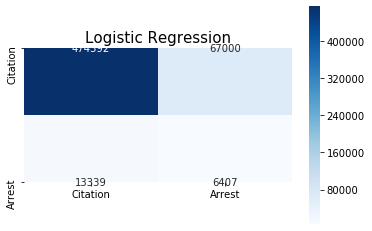

In [30]:
cm = confusion_matrix(y_val, preds)
sns.heatmap(cm,
            cmap=plt.cm.Blues,
            annot=True,
            square=True,
            xticklabels=['Citation', 'Arrest'],
            yticklabels=['Citation', 'Arrest'],
            fmt='g')
plt.title('Logistic Regression', size=15);

This helped recall a bit, but precision is worse. 

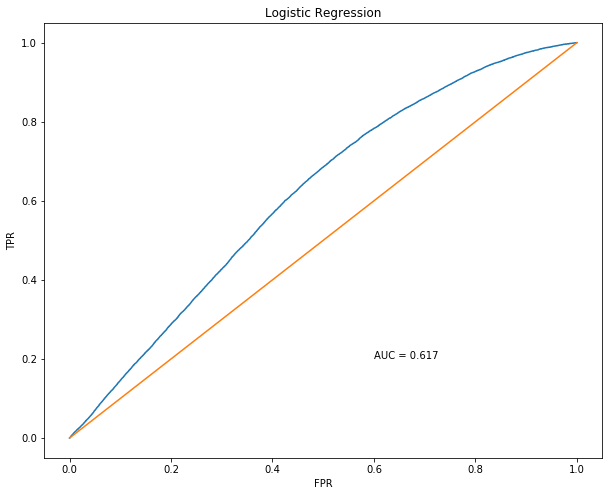

In [31]:
pred_probs = base_logistic.predict_proba(X_val)[:, 1]
plot_roc(y_val, pred_probs, 'Logistic Regression')

# Fourth Base Model - Add Violation

In [32]:
cols2keep = ['outcome', 'subject_age', 'subject_race', 'subject_sex', 'officer_age', 'officer_race', 'officer_sex', 
             'officer_years_of_service', 'county_name', 'vehicle_region', 'violation']
cols2dum = ['subject_race', 'subject_sex', 'officer_race', 'officer_sex', 'county_name', 'vehicle_region', 'violation']

df_fl_dropnas = pd.read_pickle('data/df_fl_dropnas.pkl')
df_fl_sub = df_fl_dropnas[cols2keep]
del df_fl_dropnas # for memory purposes

In [33]:
# Fix negative values in officer years of service
df_fl_sub['officer_years_of_service'] = np.abs(df_fl_sub['officer_years_of_service'])

In [34]:
# Dummify
df_fl_sub_dums = pd.get_dummies(df_fl_sub, columns=cols2dum, prefix=cols2dum, drop_first=True)
del df_fl_sub

In [35]:
# Binarize outcome
df_fl_sub_dums = binarize_outcome(df_fl_sub_dums)

In [36]:
X = df_fl_sub_dums.drop('outcome', axis=1)
y = df_fl_sub_dums['outcome']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=rs)

In [37]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)

base_logistic = LogisticRegression(class_weight={0: 1, 1: 15})
base_logistic.fit(X_train_sc, y_train)
preds = base_logistic.predict(X_val_sc)
print(f'Accuracy is {round(accuracy_score(y_val, preds), 3)}')
print(f'Precision is {round(precision_score(y_val, preds), 3)}')
print(f'Recall is {round(recall_score(y_val, preds), 3)}')
print(f'F1 is {round(f1_score(y_val, preds), 3)}')

/Users/markyramone/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy is 0.92
Precision is 0.232
Recall is 0.554
F1 is 0.327


In [38]:
list(sorted(zip(X_val.columns, base_logistic.coef_[0]), key=lambda tup: tup[1], reverse=True))

[('subject_race_hispanic', 0.4362355284699144),
 ('subject_race_black', 0.4314721762824371),
 ('subject_sex_male', 0.25686647474066987),
 ('county_name_DUVAL', 0.2302770314326874),
 ('officer_race_white', 0.2294364443593221),
 ('violation_CONTRABAND', 0.17808631685659893),
 ('subject_race_white', 0.16138094160745686),
 ('county_name_ESCAMBIA', 0.14191558590058714),
 ('county_name_PALM BEACH', 0.13556961915121718),
 ('officer_race_black', 0.1331209721874586),
 ('officer_race_hispanic', 0.11981794485602056),
 ('county_name_NASSAU', 0.11141972601394913),
 ('violation_ALCOHOL', 0.09681691023803804),
 ('county_name_HERNANDO', 0.07837347253504516),
 ('county_name_MIAMI-DADE', 0.07762034370217359),
 ('county_name_BROWARD', 0.07754631885989081),
 ('county_name_VOLUSIA', 0.07123251302274156),
 ('county_name_HILLSBOROUGH', 0.06364205640581874),
 ('county_name_ORANGE', 0.059183922516763555),
 ('county_name_PASCO', 0.05515706970572493),
 ('subject_race_other/unknown', 0.05369242075929032),
 ('coun

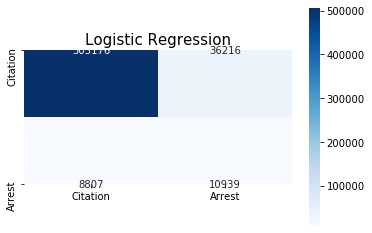

In [39]:
cm = confusion_matrix(y_val, preds)
sns.heatmap(cm,
            cmap=plt.cm.Blues,
            annot=True,
            square=True,
            xticklabels=['Citation', 'Arrest'],
            yticklabels=['Citation', 'Arrest'],
            fmt='g')
plt.title('Logistic Regression', size=15);

Not surprising that adding violation improves things substantially. Precision still quite garbage. But interesting that race-related coefficients (i.e. black, hispanic driver) are pretty solidly the strongest drivers (ha).

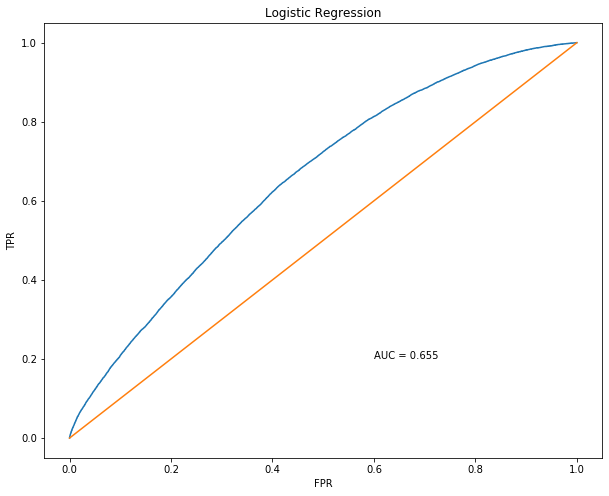

In [40]:
pred_probs = base_logistic.predict_proba(X_val)[:, 1]
plot_roc(y_val, pred_probs, 'Logistic Regression')

# Final Base Model - Add Search Related Info

In [41]:
cols2keep = ['outcome', 'subject_age', 'subject_race', 'subject_sex', 'officer_age', 'officer_race', 'officer_sex', 
             'officer_years_of_service', 'county_name', 'vehicle_region', 'violation', 'search_conducted',
             'search_basis', 'frisk_performed']
cols2dum = ['subject_race', 'subject_sex', 'officer_race', 'officer_sex', 'county_name', 'vehicle_region', 
            'violation', 'search_conducted', 'search_basis', 'frisk_performed']

df_fl_dropnas = pd.read_pickle('data/df_fl_dropnas.pkl')
df_fl_sub = df_fl_dropnas[cols2keep]
del df_fl_dropnas # for memory purposes

In [42]:
# Dummify
df_fl_sub_dums = pd.get_dummies(df_fl_sub, columns=cols2dum, prefix=cols2dum, drop_first=True)
del df_fl_sub

In [43]:
# Binarize outcome
df_fl_sub_dums = binarize_outcome(df_fl_sub_dums)

In [44]:
X = df_fl_sub_dums.drop('outcome', axis=1)
y = df_fl_sub_dums['outcome']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=rs)

In [45]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)

base_logistic = LogisticRegression(class_weight={0: 1, 1: 15})
base_logistic.fit(X_train_sc, y_train)
preds = base_logistic.predict(X_val_sc)
print(f'Accuracy is {round(accuracy_score(y_val, preds), 3)}')
print(f'Precision is {round(precision_score(y_val, preds), 3)}')
print(f'Recall is {round(recall_score(y_val, preds), 3)}')
print(f'F1 is {round(f1_score(y_val, preds), 3)}')

/Users/markyramone/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy is 0.928
Precision is 0.263
Recall is 0.575
F1 is 0.361


In [46]:
list(sorted(zip(X_val.columns, base_logistic.coef_[0]), key=lambda tup: tup[1], reverse=True))

[('subject_race_hispanic', 0.44247207816555195),
 ('subject_race_black', 0.42931394618754537),
 ('officer_race_white', 0.2538658514522965),
 ('subject_sex_male', 0.24168472236604535),
 ('county_name_DUVAL', 0.23768831073759164),
 ('officer_race_black', 0.17928508189511108),
 ('county_name_PALM BEACH', 0.16461935895214128),
 ('county_name_ESCAMBIA', 0.16073680917946234),
 ('subject_race_white', 0.15662264280076382),
 ('officer_race_hispanic', 0.1532619752921963),
 ('violation_CONTRABAND', 0.1483532676707802),
 ('search_basis_other', 0.13172186563977578),
 ('county_name_BROWARD', 0.09855937968683458),
 ('county_name_MIAMI-DADE', 0.09649932968135864),
 ('violation_ALCOHOL', 0.09242442330768115),
 ('county_name_HERNANDO', 0.089090843749105),
 ('search_conducted_True', 0.08644637538732158),
 ('county_name_NASSAU', 0.0832396730027174),
 ('county_name_HILLSBOROUGH', 0.08162347357754061),
 ('county_name_ORANGE', 0.0783196069950089),
 ('county_name_SANTA ROSA', 0.06542368039164487),
 ('county_n

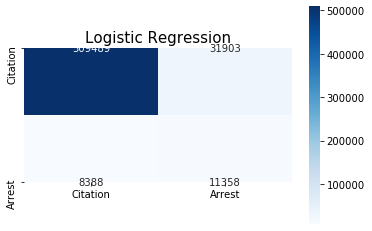

In [47]:
cm = confusion_matrix(y_val, preds)
sns.heatmap(cm,
            cmap=plt.cm.Blues,
            annot=True,
            square=True,
            xticklabels=['Citation', 'Arrest'],
            yticklabels=['Citation', 'Arrest'],
            fmt='g')
plt.title('Logistic Regression', size=15);

Very marginal improvement, a bit surprising. Violation continues to be the biggest improvement upon demographics, but still race-related coefficients are strongest.

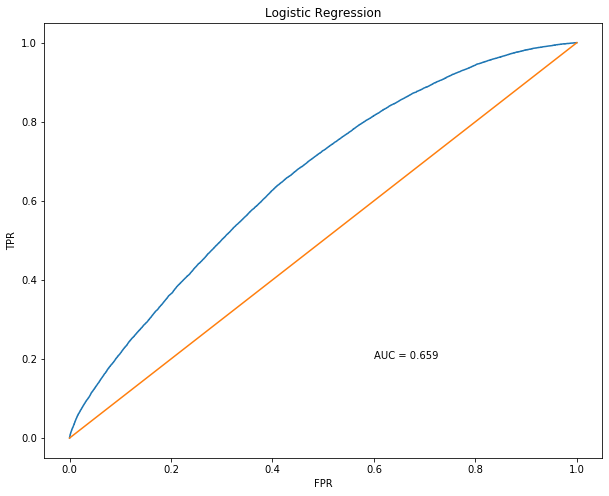

In [48]:
pred_probs = base_logistic.predict_proba(X_val)[:, 1]
plot_roc(y_val, pred_probs, 'Logistic Regression')

# Bring in time of day, day of week, month columns

In [49]:
cols2keep = ['outcome', 'subject_age', 'subject_race', 'subject_sex', 'officer_age', 'officer_race', 'officer_sex', 
             'officer_years_of_service', 'county_name', 'vehicle_region', 'violation', 'search_conducted',
             'search_basis', 'frisk_performed', 'time_of_day', 'day_of_week', 'month']
cols2dum = ['subject_race', 'subject_sex', 'officer_race', 'officer_sex', 'county_name', 'vehicle_region', 
            'violation', 'search_conducted', 'search_basis', 'frisk_performed', 'time_of_day', 'day_of_week', 'month']

df_fl_dropnas = pd.read_pickle('data/df_fl_dropnas.pkl')
df_fl_sub = df_fl_dropnas[cols2keep]
del df_fl_dropnas # for memory purposes

In [50]:
# Dummify
df_fl_sub_dums = pd.get_dummies(df_fl_sub, columns=cols2dum, prefix=cols2dum, drop_first=True)
del df_fl_sub

In [51]:
df_fl_sub_dums.shape

(2805687, 137)

In [52]:
# Binarize outcome
df_fl_sub_dums = binarize_outcome(df_fl_sub_dums)

In [53]:
X = df_fl_sub_dums.drop('outcome', axis=1)
y = df_fl_sub_dums['outcome']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=rs)

In [54]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)

base_logistic = LogisticRegression(class_weight={0: 1, 1: 15})
base_logistic.fit(X_train_sc, y_train)
preds = base_logistic.predict(X_val_sc)
print(f'Accuracy is {round(accuracy_score(y_val, preds), 3)}')
print(f'Precision is {round(precision_score(y_val, preds), 3)}')
print(f'Recall is {round(recall_score(y_val, preds), 3)}')
print(f'F1 is {round(f1_score(y_val, preds), 3)}')

/Users/markyramone/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy is 0.926
Precision is 0.257
Recall is 0.587
F1 is 0.358


In [55]:
list(sorted(zip(X_val.columns, base_logistic.coef_[0]), key=lambda tup: tup[1], reverse=True))

[('subject_race_hispanic', 0.4481030817710335),
 ('subject_race_black', 0.43043610090544676),
 ('county_name_DUVAL', 0.25195732431988194),
 ('officer_race_white', 0.23757110374605497),
 ('subject_sex_male', 0.2313769784208442),
 ('county_name_PALM BEACH', 0.16860881348738768),
 ('county_name_ESCAMBIA', 0.16780465209825032),
 ('subject_race_white', 0.16733172239003413),
 ('officer_race_black', 0.166860090335751),
 ('violation_CONTRABAND', 0.15059513003878727),
 ('officer_race_hispanic', 0.14114311283826322),
 ('search_basis_other', 0.12359973866721477),
 ('county_name_MIAMI-DADE', 0.10391141825864224),
 ('county_name_BROWARD', 0.09536598253031651),
 ('county_name_HERNANDO', 0.09112223602936827),
 ('search_conducted_True', 0.08675107779042408),
 ('county_name_NASSAU', 0.08265641434295024),
 ('county_name_HILLSBOROUGH', 0.07900000206156066),
 ('violation_ALCOHOL', 0.07835001148494013),
 ('county_name_SANTA ROSA', 0.06902394921376342),
 ('county_name_VOLUSIA', 0.06467221418076356),
 ('coun

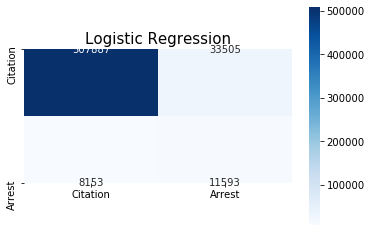

In [56]:
cm = confusion_matrix(y_val, preds)
sns.heatmap(cm,
            cmap=plt.cm.Blues,
            annot=True,
            square=True,
            xticklabels=['Citation', 'Arrest'],
            yticklabels=['Citation', 'Arrest'],
            fmt='g')
plt.title('Logistic Regression', size=15);

Very marginal improvement, a bit surprising. Violation continues to be the biggest improvement upon demographics, but still race-related coefficients are strongest.

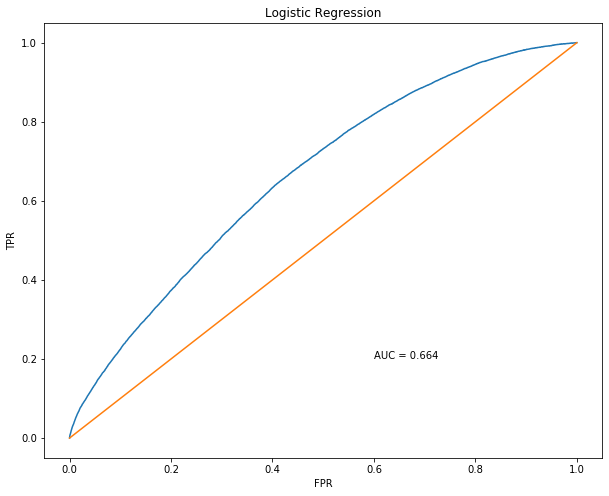

In [57]:
pred_probs = base_logistic.predict_proba(X_val)[:, 1]
plot_roc(y_val, pred_probs, 'Logistic Regression')